<a href="https://colab.research.google.com/github/yabbou/python-data-science/blob/main/project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Evaluating Machine Learning Performance Project**
==

Introduction
==

**Research Question:** analysing the nature of machine learning predictions.

**Variables:** 181 binary classifications. A classification model has been used to “predict” the actual classifications for each observation.

The data set includes three attributes that we will make use of for our analysis:

1. **class**: the observation's classification 
2. **scored.class**: the predicted classification, predicted according to `scored.probability` (ie. `1` when `scored.probability` is greater than 0.50)
3. **scored.probability**: the classification model’s probability score for the observation

**Summary:**

Step 1: Introduction

Step 2: Calculating Confusion Matrix

Step 3: Extracting Matrix Values

Step 4: Manually Calculating Metrics   

Step 5: Manually Calculating ROC curve, AUC, and Probabilities

Step 6: Conclusion


Part 2: Calculating Confusion Matrix
==

Here is our data:

In [11]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from yellowbrick.classifier import ROCAUC

import warnings
warnings.filterwarnings("ignore")

data_df = pd.read_csv("https://raw.githubusercontent.com/MatthewFried/Udemy/master/Day4/Day4%20Data.csv")
backup_df = data_df.copy()
data_df.head()

,pregnant,glucose,diastolic,skinfold,insulin,bmi,pedigree,age,class,scored.class,scored.probability
0,7,124,70,33,215,25.5,0.161,37,0,0,0.328452
1,2,122,76,27,200,35.9,0.483,26,0,0,0.273190
2,3,107,62,13,48,22.9,0.678,23,1,0,0.109660
3,1,91,64,24,0,29.2,0.192,21,0,0,0.055998
4,4,83,86,19,0,29.3,0.317,34,0,0,0.100491


Use Pandas’ `crosstab()` function to calculate the contents of a confusion matrix for the data. Do the rows and columns represent either the actual or the predicted classification?  
>HINT: check the `value_counts()` for the dataframe columns you’ve used as input to the `crosstab()` function. Do the rows or columns in the crosstab() output sum to the respective `value_counts()` figures?


How many data points are we working with?

In [12]:
rows = data_df.shape[0]
print('Rows:',rows)

Rows: 181


Are there any null values for which to account?

In [13]:
nulls = data_df.isnull().sum()
nulls

pregnant              0
glucose               0
diastolic             0
skinfold              0
insulin               0
bmi                   0
pedigree              0
age                   0
class                 0
scored.class          0
scored.probability    0
dtype: int64

None.

A confusion matrix is made up of true and false positives and negatives.

* **True**: accuratly predicted value (ie. predicted 1 for dataset value of 1)

* **Positive**: 1 
* **Negative**: 0  

Here is a confusion matrix using the `confusion_matrix` method:

In [14]:
y_actual = data_df['class'] 
y_predicted = data_df['scored.class']
matrix = confusion_matrix(y_actual, y_predicted)

pd.DataFrame(matrix, columns=["Predicted 0","Predicted 1",], index=["True 0", "True 1"])

,Predicted 0,Predicted 1
True 0,119,5
True 1,30,27


There are 119 accurate predictions of `0` and 27 accurate predictions of `1`. 

30 predictions of `0` are inaccurate (that is a fair amount), and 5 predictions of `1` are inaccurate. 

* 119 true negatives
* 5 false positives
* 30 false negatives 
* 27 true positives


Here is the matrix using the `crosstab()` method:

In [15]:
pd.crosstab(y_actual, y_predicted, margins=True, margins_name="Total", dropna=False)

scored.class,0,1,Total
class,,,
0,119,5,124
1,30,27,57
Total,149,32,181


This method adds the rows column details. The sum of either the columns or the rows will add to the total number of observations: **181**. From the output of confusion matrix we know that the **rows** represent the *actual* classifications and the **columns** represent the *predicted* classifications. 

Hence the total number of the *actual* classifications of 0 is **124** and of 1 is **57**. 

There were **149** *predicted* 0 and **32** predicted 1 values.

>Note that even the diagonals add to 181:
>
>119+27=**146** accurate predictions, and 30+5=**35** innaccurate. 146+35=**181**.

The actual and predicted observations could also be counted using `value_counts`:

In [16]:
data_df['class'].value_counts().rename_axis('Actual').to_frame('Observations') 

,Observations
Actual,
0,124
1,57


In [17]:
data_df['scored.class'].value_counts().rename_axis('Predicted').to_frame('Observations')

,Observations
Predicted,
0,149
1,32


The data evidently parallels the margins in the `crosstab()` method.
>Note: these lines were not constructed as a method in order to maintain the automatic graph display.


Part 3: Extracting Matrix Values
==

Here the individual confusion matrix values (True Positive, False Positive, True Negative, False Negative) are extracted from the output of the `crosstab()` function and save them for later use. 

In [18]:
def getConfusionMatrixValues(y_actual, y_predicted):
  tp = ((y_actual == 1) & (y_actual == y_predicted)).sum()  
  tn = ((y_actual == 0) & (y_actual == y_predicted)).sum() 
  
  fp = ((y_actual == 0) & (y_actual != y_predicted)).sum()  
  fn = ((y_actual == 1) & (y_actual != y_predicted)).sum()  
  return tp, tn, fp, fn

TP,TN,FP,FN = getConfusionMatrixValues(y_actual, y_predicted)
matrix_df = pd.DataFrame({'Confusion Matrix':['True Negative', 'True Positive','False Negative','False Positive'], 'Count': [TN,TP,FN,FP]})
matrix_df

,Confusion Matrix,Count
0,True Negative,119
1,True Positive,27
2,False Negative,30
3,False Positive,5


Part 4: Manually Calculating Metrics   
==

Here is a Python function that accepts as input the actual and predicted classifications for any binary classification data, then calculates and returns the `accuracy` metric for the predictions __without__ utilizing any pre-built Python accuracy metric calculation functions. The same for `precision`, `sensitivity`, `specificity`, and `F1_score`. See [here](https://medium.com/@MohammedS/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b) for details.


In [19]:
def calcAccuracy(tp,tn,fp,fn): #percent of accurate (true) predictions
  return (tp + tn) / (tp + tn + fp + fn)

def calcRecall(tp,fn): #percent of positives accurately predicted 
  return tp / (tp + fn)

def calcPrecision(tp,fp): #percent of positives predicted 
  return tp / (tp + fp)

def calcSpecificity(tn,fp): #percent of negatives accurately predicted 
 return tn / (tn + fp)

def calcF1(tp,fp,fn): #harmonic mean between precision and recall
  pre = calcPrecision(tp,fp)
  rec = calcRecall(tp,fn)
  return (2 * pre * rec) / (pre + rec)

In [20]:
def getManualStatistics():
  tp, tn, fp, fn = getConfusionMatrixValues(y_actual, y_predicted) 

  acc = calcAccuracy(tp,tn,fp,fn)
  rec = calcRecall(tp,fn)
  pre = calcPrecision(tp,fp) 
  spe = calcSpecificity(tn,fn) 
  f1  = calcF1(tp,fp,fn)
  return acc, rec, pre, spe, f1

def getBuiltinStatistics(actual, predicted):
  accuracy = accuracy_score(actual,predicted)
  recall = recall_score(actual,predicted)
  precision = precision_score(actual,predicted)
  specificity = recall_score(predicted,actual,pos_label=0)
  f1 = f1_score(actual,predicted)
  return accuracy, recall, precision, specificity, f1

def displayResults():
  acc, rec, pre, spe, f1 = getManualStatistics()
  accuracy, recall, precision, specificity, f1_actual = getBuiltinStatistics(y_actual,y_predicted)
    
  displaySpecificRes('Accuracy',acc,accuracy)
  displaySpecificRes('Recall',rec,recall)
  displaySpecificRes('Precision',pre,precision)
  displaySpecificRes('Specificity',spe,specificity)
  displaySpecificRes('F1',f1,f1_actual)

def displaySpecificRes(stat,manual,builtin):
  print(f'Manual {stat:<13}  {manual}\nBuilt-in {stat:<12} {builtin}\n')
  
displayResults()

Manual Accuracy       0.8066298342541437
Built-in Accuracy     0.8066298342541437

Manual Recall         0.47368421052631576
Built-in Recall       0.47368421052631576

Manual Precision      0.84375
Built-in Precision    0.84375

Manual Specificity    0.7986577181208053
Built-in Specificity  0.7986577181208053

Manual F1             0.6067415730337079
Built-in F1           0.6067415730337079



Thankfully, all the manual calcualtions match the built-in calculations.

Part 5: Manually Calculating ROC Curve, AUC, and Probabilities
==

Here is a Python function to manually plot a ROC curve, and the AUC for both the binary classifications and their probabilities (without utilizing the pre-built Python classification metric functions).

**Receiver Operating Characteristic** (ROC): displays the false positive rate (probability of prediction=1 and true value=0) on the X-axis, against the true positive rate (probability of prediction=1 and true value=1) on Y-axis. Ideally, the curve will climb quickly toward the top-left meaning the model correctly predicted the cases. Used to compare classification models. 

**Area Under the Curve** (AUC): definite integral, the area under thae graph; calculated by `Numpy` using the "trapezoidal rule". See [here](https://en.wikipedia.org/wiki/Trapezoidal_rule) for details.

In [23]:
def roc(actual, predicted):
  tp = 0
  fp = 0
  tn = 0
  fn = 0
  predicted = pd.Series(predicted, index = actual.index)

  for i in actual.index:
    if actual[i] == predicted[i] == 1:
      tp += 1
    if actual[i] == predicted[i] == 0:
      tn += 1
    if predicted[i] == 1 and predicted[i] != actual[i]:
      fp += 1
    if predicted[i] == 0 and predicted[i] != actual[i]:
      fn += 1
  return calcRecall(tp,fn), (fp / (fp + tn)) #fp = 1 - tn, and tn is the numerator for "specificity"

def calcROC(data_df):
  tp_rates=[]
  fp_rates=[]
  probability_thresholds = np.linspace(0,1,num=data_df.shape[0])
  
  y_actual = data_df['class']
  y_probabilities = data_df['scored.probability']

  for prob in probability_thresholds:
    y_predicted = []
    for yp in y_probabilities:
      y_predicted.append(1 if yp > prob else 0)
              
    tp_rate, fp_rate = roc(y_actual, y_predicted)
    tp_rates.append(tp_rate)
    fp_rates.append(fp_rate)

  return tp_rates, fp_rates

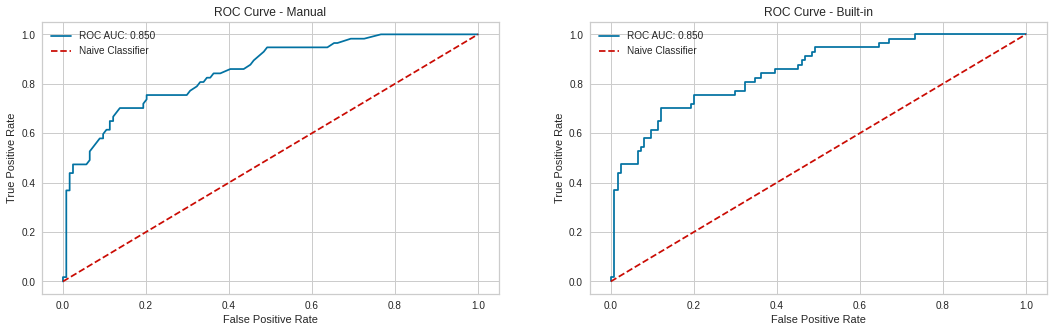

In [35]:
def displayROC(x,y,title,auc):
  plt.plot(x,y, label = "ROC AUC: %0.3f" % auc)
  plt.plot([0, 1],[0, 1], 'r--', label = "Naive Classifier") #random classifier

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve - ' + title)
  plt.legend()

def calcAUC(true_p, false_p):
  true_p.sort()
  false_p.sort()
  return np.trapz(true_p,false_p) #trapz for "trapezoidal rule"

fig, ax = plt.subplots(figsize=(18,5))
y_probabilities = data_df['scored.probability']

plt.subplot(1,2,1)
true_positives, false_positives = calcROC(data_df)
auc = calcAUC(true_positives, false_positives)
displayROC(false_positives,true_positives,'Manual',auc)

plt.subplot(1,2,2)
fp, tp, thresholds = roc_curve(y_actual, y_probabilities)
auc = roc_auc_score(y_actual, y_probabilities)
displayROC(fp,tp,'Built-in',auc)

plt.show()

Conclusion
==

We have a large area under the curve, rising rapidly, as displayed in the above charts. The manual accuracy metrics thankfully produce identical results as the Python libraries. 

The model seems to predict a fair percent of true positives (90%) with many less false negatives (50%).